In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
%matplotlib inline

In [6]:
# Load in industry crosswalk, which documents what NAICS sectors correspond to the CPS level of aggregation
ind_dict = pd.read_excel("../../data/raw/OES_industry_crosswalk.xlsx")
occ_by_ind = pd.read_excel("../../data/raw/OES/natsector_M2021_dl.xlsx")
occ_3d = pd.read_excel("../../data/raw/OES/nat3d_M2021_dl.xlsx")
long_short_names = pd.read_excel("../../data/raw/long_short_names_crosswalk.xlsx")
index_dict = dict(zip(long_short_names['Industry'], long_short_names['short_names']))

In [7]:
# Compute HR count for non-manufacturing 
hr = occ_by_ind[occ_by_ind['OCC_TITLE'].str.lower().str.contains('human resources')]
hr = hr[hr['O_GROUP'] == 'broad'][['NAICS', "OCC_CODE", 'NAICS_TITLE', "OCC_TITLE", "TOT_EMP"]]
hr.loc[:, 'TOT_EMP'] = pd.to_numeric(hr['TOT_EMP'], errors='coerce').fillna(0)
hr = hr.groupby(['NAICS_TITLE', 'NAICS'])['TOT_EMP'].sum().reset_index()
hr = hr[hr['NAICS'] != '31-33']
hr.head()

,NAICS_TITLE,NAICS,TOT_EMP
0,Accommodation and Food Services,72,13430.0
1,Administrative and Support and Waste Managemen...,56,186680.0
2,"Agriculture, Forestry, Fishing and Hunting",11,90.0
3,"Arts, Entertainment, and Recreation",71,8280.0
4,Construction,23,18050.0


In [8]:
# compute HR count for manufacturing
manu_dict = {'Nondur': list(range(311, 317)) + list(range(322, 327)),
             'Dur': [321, 327, 339] + list(range(331, 338))}

# Helper for retrieving industry names
def helper(x, manu_dict):
    for k, v in manu_dict.items():
        if x in v:
            return k
        else:
            None

# filter occupations containing human resources and compute the employment of human resources-related occupations
hr_3d = occ_3d[occ_3d['OCC_TITLE'].str.lower().str.contains('human resources')]
hr_3d = hr_3d[hr_3d['O_GROUP'] == 'broad'][['NAICS', "OCC_CODE", 'NAICS_TITLE', "OCC_TITLE", "TOT_EMP"]]
hr_3d.loc[:, 'TOT_EMP'] = pd.to_numeric(hr_3d['TOT_EMP'], errors='coerce').fillna(0)
hr_3d.loc[:, 'NAICS'] = hr_3d['NAICS'] // 1000
hr_3d.loc[:, 'NAICS_TITLE'] = hr_3d['NAICS'].apply(lambda x: helper(x, manu_dict)).dropna()
hr_3d = hr_3d.dropna(subset=['NAICS_TITLE']).groupby(['NAICS_TITLE', 'NAICS'])['TOT_EMP'].sum().reset_index()
hr_3d.loc[:, "NAICS"] = hr_3d['NAICS_TITLE'].transform(lambda x: '33DG' if x == 'Dur' else '31ND')

In [9]:
hr = pd.concat([hr_3d, hr])
hr = pd.merge(hr, ind_dict, on='NAICS_TITLE', how='inner').drop(columns=['NAICS_TITLE'])
hr.head()

,NAICS,TOT_EMP,Industry
0,33DG,1480.0,Durable goods manufacturing
1,33DG,1740.0,Durable goods manufacturing
2,33DG,2730.0,Durable goods manufacturing
3,33DG,7890.0,Durable goods manufacturing
4,33DG,7720.0,Durable goods manufacturing


In [10]:
hr = hr.groupby(['Industry'])['TOT_EMP'].sum().reset_index()
hr.head()

,Industry,TOT_EMP
0,Construction,18050.0
1,Durable goods manufacturing,51040.0
2,Education and health services,163750.0
3,Financial activities,65380.0
4,Government,105430.0


In [11]:
# Then, we filter the major occupation groups
# and compute the labor expenditure on these major occupations
occ_by_ind = occ_by_ind[occ_by_ind['O_GROUP'] == 'major'][['NAICS', 'NAICS_TITLE', "OCC_CODE", "OCC_TITLE", "TOT_EMP", "A_MEAN"]]
occ_by_ind.loc[:, 'TOT_EMP'] = pd.to_numeric(occ_by_ind['TOT_EMP'], errors='coerce').fillna(0)
occ_by_ind.loc[:, 'A_MEAN'] = pd.to_numeric(occ_by_ind['A_MEAN'], errors='coerce').fillna(0)
occ_by_ind.loc[:, "WL"] = occ_by_ind.loc[:, 'TOT_EMP'] * occ_by_ind.loc[:, 'A_MEAN']
# Take out manufacturing and put in durable and nondurable manufacturing
occ_by_ind = occ_by_ind[occ_by_ind['NAICS'] != '31-33']

In [12]:
occ_3d = occ_3d[occ_3d['O_GROUP'] == 'major'][['NAICS', 'NAICS_TITLE', "OCC_CODE", "OCC_TITLE", "TOT_EMP", "A_MEAN"]]
occ_3d.loc[:, 'TOT_EMP'] = pd.to_numeric(occ_3d['TOT_EMP'], errors='coerce').fillna(0)
occ_3d.loc[:, 'A_MEAN'] = pd.to_numeric(occ_3d['A_MEAN'], errors='coerce').fillna(0)
occ_3d.loc[:, 'NAICS'] = occ_3d['NAICS'] // 1000

# Helper for retrieving industry names
def helper(x, manu_dict):
    for k, v in manu_dict.items():
        if x in v:
            return k
        else:
            None
occ_3d.loc[:, 'NAICS_TITLE'] = occ_3d['NAICS'].apply(lambda x: helper(x, manu_dict)).dropna()
occ_3d.loc[:, "WL"] = occ_3d.loc[:, 'TOT_EMP'] * occ_3d.loc[:, 'A_MEAN']
occ_3d

,NAICS,NAICS_TITLE,OCC_CODE,OCC_TITLE,TOT_EMP,A_MEAN,WL
1,113,NaN,11-0000,Management Occupations,1060.0,118470.0,125578200.0
8,113,NaN,13-0000,Business and Financial Operations Occupations,0.0,71650.0,0.0
17,113,NaN,15-0000,Computer and Mathematical Occupations,0.0,69050.0,0.0
18,113,NaN,17-0000,Architecture and Engineering Occupations,0.0,73180.0,0.0
19,113,NaN,19-0000,"Life, Physical, and Social Science Occupations",910.0,76450.0,69569500.0
...,...,...,...,...,...,...,...
38382,999,NaN,45-0000,"Farming, Fishing, and Forestry Occupations",20570.0,44960.0,924827200.0
38399,999,NaN,47-0000,Construction and Extraction Occupations,444400.0,54070.0,24028708000.0
38472,999,NaN,49-0000,"Installation, Maintenance, and Repair Occupations",411030.0,57630.0,23687658900.0
38535,999,NaN,51-0000,Production Occupations,167960.0,59160.0,9936513600.0


In [13]:
# aggregate 3-digit sectors to durable and nondurable and compute total employment and wage expenditures
occ_manu = occ_3d.dropna(subset=['NAICS_TITLE']).groupby(['NAICS_TITLE', 'OCC_CODE', 'OCC_TITLE']).agg({'TOT_EMP':'sum','WL':'sum'}).reset_index()
# assign naics codes
occ_manu.loc[:, "NAICS"] = occ_manu['NAICS_TITLE'].transform(lambda x: '33DG' if x == 'Dur' else '31ND')
occ_by_ind = pd.concat([occ_manu, occ_by_ind])
occ_by_ind = pd.merge(occ_by_ind, ind_dict, on='NAICS_TITLE', how='inner').drop(columns=['NAICS_TITLE', 'A_MEAN'])

In [14]:
occ_by_ind[['Industry', 'NAICS']].drop_duplicates()

,Industry,NAICS
0,Durable goods manufacturing,33DG
22,Nondurable goods manufacturing,31ND
44,"Mining, quarrying, and oil and gas extraction",21
64,Transportation and utilities,22
82,Construction,23
104,Wholesale and retail trade,42
126,Wholesale and retail trade,44-45
148,Transportation and utilities,48-49
157,Information,51
178,Financial activities,52


In [15]:
# compute employment share and wage expenditure share. Here the wage expenditure shares are not normalized by labor shares
occ_by_ind = occ_by_ind.groupby(['Industry', 'OCC_CODE', 'OCC_TITLE']).sum().reset_index()
occ_by_ind.loc[:, 'EMP_PCT'] = occ_by_ind['TOT_EMP']/occ_by_ind.groupby('OCC_CODE')['TOT_EMP'].transform(sum)
occ_by_ind.loc[:, 'WL_PCT'] = occ_by_ind['WL']/occ_by_ind.groupby('Industry')['WL'].transform(sum)

curlyL = occ_by_ind.pivot_table(columns=['OCC_TITLE'], index=['Industry'], values='EMP_PCT').fillna(0)
L = occ_by_ind.pivot_table(columns=['OCC_TITLE'], index=['Industry'], values='TOT_EMP').fillna(0)
epsN = occ_by_ind.pivot_table(columns=['OCC_TITLE'], index=['Industry'], values='WL_PCT').fillna(0)
occ_by_ind

/var/folders/6v/95rnbl092sj9w9s2l5v2t5l00000gn/T/ipykernel_2166/1818445888.py:3: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  occ_by_ind.loc[:, 'EMP_PCT'] = occ_by_ind['TOT_EMP']/occ_by_ind.groupby('OCC_CODE')['TOT_EMP'].transform(sum)
/var/folders/6v/95rnbl092sj9w9s2l5v2t5l00000gn/T/ipykernel_2166/1818445888.py:4: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  occ_by_ind.loc[:, 'WL_PCT'] = occ_by_ind['WL']/occ_by_ind.groupby('Industry')['WL'].transform(sum)


,Industry,OCC_CODE,OCC_TITLE,TOT_EMP,WL,NAICS,EMP_PCT,WL_PCT
0,Construction,11-0000,Management Occupations,535260.0,60329154600.0,23,0.060142,0.134188
1,Construction,13-0000,Business and Financial Operations Occupations,398740.0,32708642200.0,23,0.044744,0.072753
2,Construction,15-0000,Computer and Mathematical Occupations,19100.0,1480823000.0,23,0.004136,0.003294
3,Construction,17-0000,Architecture and Engineering Occupations,93640.0,7222453200.0,23,0.038903,0.016065
4,Construction,19-0000,"Life, Physical, and Social Science Occupations",17530.0,1345252200.0,23,0.013925,0.002992
...,...,...,...,...,...,...,...,...
275,Wholesale and retail trade,45-0000,"Farming, Fishing, and Forestry Occupations",68330.0,2282561000.0,4244-45,0.437508,0.002464
276,Wholesale and retail trade,47-0000,Construction and Extraction Occupations,67520.0,3280363300.0,4244-45,0.011546,0.003542
277,Wholesale and retail trade,49-0000,"Installation, Maintenance, and Repair Occupations",1109630.0,54271379500.0,4244-45,0.199394,0.058594
278,Wholesale and retail trade,51-0000,Production Occupations,656200.0,25464463200.0,4244-45,0.078164,0.027493


In [42]:
occ_by_ind.groupby('OCC_CODE')['TOT_EMP'].transform(sum)



/var/folders/6v/95rnbl092sj9w9s2l5v2t5l00000gn/T/ipykernel_1459/1120074406.py:1: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  temp = occ_by_ind.groupby('OCC_CODE')['TOT_EMP'].transform(sum)[:22]


0      8900010.0
1      8911530.0
2      4617830.0
3      2407010.0
4      1258930.0
5      2213790.0
6      1176510.0
7      8190330.0
8      1808320.0
9      8786050.0
10     6600790.0
11     3340770.0
12    11195800.0
13     4103390.0
14     2559430.0
15    13252870.0
16    18279490.0
17      156180.0
18     5848120.0
19     5565020.0
20     8395190.0
21    12593870.0
Name: TOT_EMP, dtype: object

In [16]:
## Compute recruiter-producer ratio
tot_emp = occ_by_ind.groupby('Industry')['TOT_EMP'].sum().reset_index()
tau = pd.merge(tot_emp, hr, on='Industry', suffixes=['', '_HR'])
tau.loc[:, 'Workers'] = tau['TOT_EMP'] - tau['TOT_EMP_HR']
tau.loc[:, 'Tau'] = tau['TOT_EMP_HR'] / tau['Workers']
tau = pd.merge(tau, long_short_names, on='Industry')
tau.to_csv("../../data/clean/tau_2021.csv", index=False)
tau

,Industry,TOT_EMP,TOT_EMP_HR,Workers,Tau,short_names
0,Construction,7368800.0,18050.0,7350750.0,0.002456,const
1,Durable goods manufacturing,7511780.0,51040.0,7460740.0,0.006841,dur
2,Education and health services,33322000.0,163750.0,33158250.0,0.004938,edhealth
3,Financial activities,8198430.0,65380.0,8133050.0,0.008039,fin
4,Government,9675670.0,105430.0,9570240.0,0.011016,gov
5,Information,2748830.0,34510.0,2714320.0,0.012714,info
6,Leisure and hospitality,13558650.0,21710.0,13536940.0,0.001604,accom
7,"Mining, quarrying, and oil and gas extraction",491610.0,2510.0,489100.0,0.005132,mining
8,Nondurable goods manufacturing,4583510.0,31390.0,4552120.0,0.006896,nondur
9,Other services,3831420.0,67610.0,3763810.0,0.017963,other


In [17]:
curlyL

OCC_TITLE,Architecture and Engineering Occupations,"Arts, Design, Entertainment, Sports, and Media Occupations",Building and Grounds Cleaning and Maintenance Occupations,Business and Financial Operations Occupations,Community and Social Service Occupations,Computer and Mathematical Occupations,Construction and Extraction Occupations,Educational Instruction and Library Occupations,"Farming, Fishing, and Forestry Occupations",Food Preparation and Serving Related Occupations,...,"Installation, Maintenance, and Repair Occupations",Legal Occupations,"Life, Physical, and Social Science Occupations",Management Occupations,Office and Administrative Support Occupations,Personal Care and Service Occupations,Production Occupations,Protective Service Occupations,Sales and Related Occupations,Transportation and Material Moving Occupations
Industry,,,,,,,,,,,,,,,,,,,,,
Construction,0.038903,0.005867,0.009485,0.044744,0.000095,0.004136,0.751917,0.000027,0.006723,0.000071,...,0.117996,0.001793,0.013925,0.060142,0.037270,0.000195,0.013831,0.002065,0.011643,0.018854
Durable goods manufacturing,0.266314,0.021689,0.006312,0.044315,0.000018,0.053101,0.029413,0.000039,0.047573,0.000056,...,0.061709,0.003876,0.024997,0.054954,0.032843,0.000020,0.450201,0.002278,0.016365,0.040078
Education and health services,0.009418,0.152158,0.207097,0.088286,0.687988,0.076248,0.009663,0.955457,0.041875,0.076237,...,0.058641,0.010310,0.225938,0.173668,0.206824,0.286497,0.010585,0.077276,0.007687,0.030205
Financial activities,0.003698,0.020433,0.031442,0.206984,0.009197,0.103417,0.005306,0.000129,0.003522,0.001651,...,0.078799,0.062209,0.003281,0.109811,0.136043,0.007826,0.001519,0.010321,0.104814,0.010070
Government,0.119106,0.039844,0.049710,0.124781,0.235497,0.059569,0.075990,0.023689,0.131707,0.005405,...,0.073860,0.227580,0.265193,0.070284,0.084229,0.071110,0.020007,0.576418,0.004051,0.030720
Information,0.016078,0.228886,0.001058,0.033800,0.000357,0.142192,0.001009,0.002024,0.000000,0.001244,...,0.038997,0.010820,0.002788,0.034892,0.019580,0.013550,0.002273,0.000961,0.023145,0.002101
Leisure and hospitality,0.000719,0.084968,0.146006,0.017617,0.000641,0.003214,0.001667,0.005522,0.024651,0.842278,...,0.037200,0.000680,0.002033,0.060716,0.031359,0.254943,0.011745,0.044385,0.043753,0.025334
"Mining, quarrying, and oil and gas extraction",0.009863,0.000171,0.000244,0.002482,0.000000,0.001221,0.032870,0.000000,0.000832,0.000008,...,0.008119,0.001071,0.009047,0.004353,0.002143,0.000016,0.003963,0.000482,0.000715,0.005257
Nondurable goods manufacturing,0.043344,0.024238,0.010898,0.017631,0.000068,0.008409,0.003791,0.000011,0.157190,0.008921,...,0.048481,0.001326,0.085064,0.027698,0.020541,0.000328,0.269277,0.001054,0.014704,0.046296


In [18]:
occ_map = {'Architecture and Engineering Occupations': 'Eng', 
           'Arts, Design, Entertainment, Sports, and Media Occupations': 'Arts',
           'Building and Grounds Cleaning and Maintenance Occupations': 'Clean',
           'Business and Financial Operations Occupations': 'Bus Ops',
           'Community and Social Service Occupations': 'Soc S',
           'Computer and Mathematical Occupations': 'Math',
           'Construction and Extraction Occupations': 'Cons',
           'Educational Instruction and Library Occupations': 'Educ',
           'Farming, Fishing, and Forestry Occupations': 'Agg',
           'Food Preparation and Serving Related Occupations': 'Food S',
           'Healthcare Practitioners and Technical Occupations': 'Health P',
           'Healthcare Support Occupations': 'Health S', 
           'Installation, Maintenance, and Repair Occupations': 'Repair', 
           'Legal Occupations': 'Legal', 'Life, Physical, and Social Science Occupations':'Science',
           'Management Occupations': 'Manag', 'Office and Administrative Support Occupations': 'Admin',
           'Personal Care and Service Occupations': 'Care', 'Production Occupations': 'Prod',
           'Protective Service Occupations': 'Prot S', 'Sales and Related Occupations': 'Sales', 
           'Transportation and Material Moving Occupations': 'Trans'}
curlyL = curlyL.rename(index=index_dict, columns=occ_map)
L = L.rename(index=index_dict, columns=occ_map)
epsN = epsN.rename(index=index_dict, columns=occ_map)

In [19]:
epsN

OCC_TITLE,Eng,Arts,Clean,Bus Ops,Soc S,Math,Cons,Educ,Agg,Food S,...,Repair,Legal,Science,Manag,Admin,Care,Prod,Prot S,Sales,Trans
Industry,,,,,,,,,,,,,,,,,,,,,
const,0.016065,0.001418,0.003258,0.072753,0.000021,0.003294,0.550658,0.000024,0.000092,0.000055,...,0.081134,0.000654,0.002992,0.134188,0.068297,0.000040,0.013440,0.000707,0.024704,0.026185
dur,0.127876,0.005517,0.001915,0.072038,0.000005,0.060475,0.019863,0.000047,0.000629,0.000061,...,0.042539,0.001747,0.005419,0.148072,0.061118,0.000004,0.366434,0.000893,0.038940,0.045172
edhealth,0.000868,0.007458,0.014346,0.026176,0.039769,0.013023,0.001631,0.242384,0.000118,0.013358,...,0.007943,0.000704,0.011057,0.081093,0.077671,0.011512,0.001684,0.005281,0.002464,0.006934
fin,0.001376,0.004293,0.007624,0.271515,0.002054,0.082443,0.002604,0.000125,0.000040,0.000991,...,0.032759,0.014066,0.000685,0.214561,0.183165,0.001344,0.000962,0.002789,0.159971,0.007936
gov,0.041069,0.007734,0.012211,0.137393,0.046286,0.038466,0.036630,0.016288,0.001410,0.003420,...,0.036110,0.043188,0.039708,0.105018,0.108859,0.009736,0.015148,0.191870,0.003617,0.033446
info,0.016482,0.125852,0.000566,0.114341,0.000175,0.291454,0.001637,0.003378,0.000000,0.001522,...,0.056258,0.008574,0.001237,0.204443,0.067585,0.004842,0.003444,0.000648,0.091594,0.004563
accom,0.000329,0.024401,0.041222,0.021583,0.000140,0.002187,0.001220,0.004946,0.000316,0.622194,...,0.018983,0.000279,0.000341,0.090772,0.043469,0.050555,0.007055,0.010916,0.037133,0.019565
mining,0.078670,0.000796,0.001053,0.061295,0.000000,0.017624,0.314956,0.000000,0.000143,0.000090,...,0.082966,0.004568,0.030027,0.160412,0.055515,0.000060,0.060679,0.001414,0.025881,0.103852
nondur,0.040517,0.009456,0.006654,0.050657,0.000036,0.014013,0.005905,0.000023,0.003692,0.013626,...,0.067645,0.001108,0.033590,0.136173,0.071847,0.000137,0.398331,0.000660,0.048978,0.095610


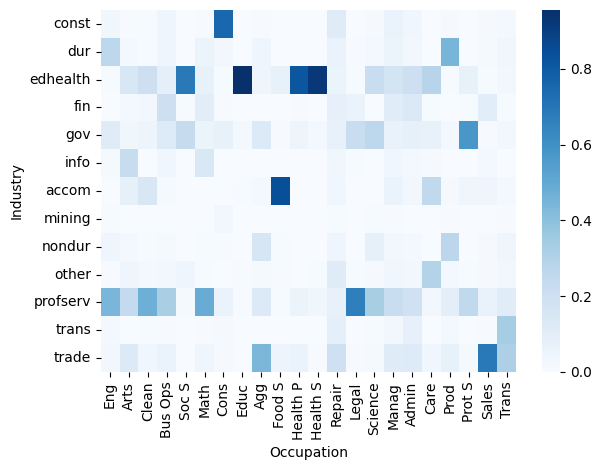

In [20]:
sns.heatmap(curlyL, cmap="Blues")
plt.xlabel('Occupation')
plt.ylabel('Industry')
plt.tight_layout()
plt.savefig('../../output/figures/occupation_2021_heatmap.png', dpi=300)

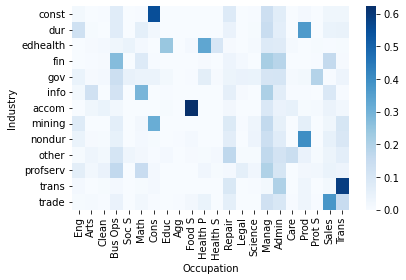

In [32]:
sns.heatmap(epsN, cmap="Blues")
plt.xlabel('Occupation')
plt.ylabel('Industry')
plt.tight_layout()

plt.savefig('../../output/figures/epsN_2021_heatmap.png',dpi=300)

In [21]:
data_dir = '../../data/clean/'
dfA      = pd.read_csv(data_dir + 'A1.csv')
dfA.columns
dfA.index = dfA.short_names
dfA = dfA.drop(labels=['short_names'],axis=1)

In [22]:
sectors_dict = {'Food S':'Accommodation and food services','Rec':'Arts, entertainment, and recreation',
                'Const':'Construction','Dur':'Durable goods','Educ S':'Educational services','Fin':'Finance and insurance',
                'Gov':'Government','Health S':'Health care and social assistance','Info':'Information','Mining':'Mining',
                'Nondur':'Nondurable goods','Other S':'Other services, except government', 'Bus S':'Professional and business services',
                'Real Est':'Real estate and rental and leasing','Retail':'Retail trade','Trans':'Transportation and warehousing',
                'Whsale':'Wholesale trade'}
sector_dict_swap = {v: k for k, v in sectors_dict.items()}
dfA = dfA.rename(index=sector_dict_swap, columns=sector_dict_swap)

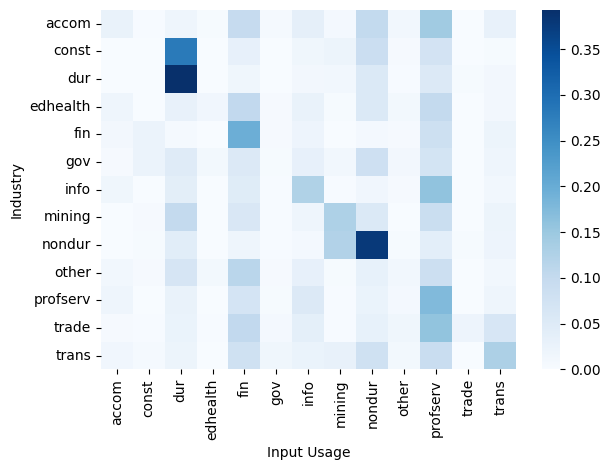

In [23]:
sns.heatmap(dfA, cmap="Blues")
plt.xlabel('Input Usage')
plt.ylabel('Industry')
plt.tight_layout()
plt.savefig('../../output/figures/sectors_heatmap.png',dpi=300)

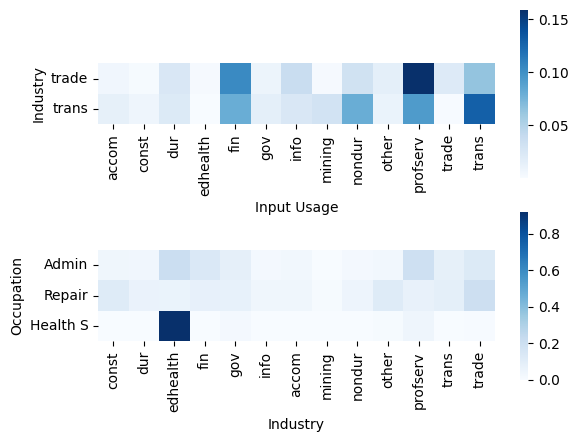

In [24]:
fig, ax =plt.subplots(2, 1)
sns.heatmap(dfA.loc[['trade', 'trans'], :], cmap="Blues", square=True, ax=ax[0])
ax[0].set_xlabel('Input Usage')
ax[0].set_ylabel('Industry')

sns.heatmap(curlyL[['Admin', 'Repair', 'Health S']].T, cmap="Blues", square=True, ax=ax[1])
ax[1].set_ylabel('Occupation')
ax[1].set_xlabel('Industry')
plt.savefig('../../output/figures/presentation/motivation.png',dpi=300)

In [25]:
# Keep only the sectors we have data for
curlyL = curlyL[curlyL.index.isin(dfA.index)]
L = L[L.index.isin(dfA.index)]
curlyL.rename(index=sectors_dict).sort_index().T.to_csv("../../data/clean/curlyL_2021.csv")
L.rename(index=sectors_dict).sort_index().T.to_csv("../../data/clean/L_2021.csv")
epsN = epsN[epsN.index.isin(dfA.index)]
epsN.rename(index=sectors_dict).sort_index().to_csv("../../data/clean/epsN_2021.csv")